# Analysis 1: National Level - Synthetic Control Method of GDP (2000-2021)

In [5]:
import pandas as pd
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#Importing the data
final_df = pd.read_csv("C:/Users/lisa/OneDrive - Nexus365/Thesis Data/new_thesis/final_df.csv")

In [7]:
#Defining the dependent variable, predictors and special_predictors
dependent_variable="GDP per capita, PPP (constant 2017 international $)"

predictors = ["Oil rents (% of GDP)",
              "Total natural resources rents (% of GDP)",
              "Trade (% of GDP)",
              "Agriculture, forestry, and fishing, value added (% of GDP)",
              "Industry (including construction), value added (% of GDP)",
              "Services, value added (% of GDP)",
              "Population density (people per sq. km of land area)",
              "GDP per capita growth (annual %)",
              "Gross capital formation (% of GDP)"]

special_predictors = ["Manufacturing, value added (% of GDP)",
                      "School enrollment, tertiary (% gross)"]

In [8]:
#Counting the number of missing values per country in the pre-intervention period
before_2014 = final_df[(final_df['YEAR'] <= 2014)]

missing_values = before_2014.groupby("COUNTRY").apply(lambda x: x.isna().sum())

In [9]:
#Removing countries that have any missing data in the dependent or a predictor variable
missing_values_dependent_predictor = missing_values.drop(columns=special_predictors)

na_sum = missing_values_dependent_predictor.sum(axis=1)

countries_without_missing_values_dependent_predictor = na_sum[na_sum==0]

In [10]:
#Removing countries missing manufacturing data twice in a row
consecutive_missing_mask = final_df["Manufacturing, value added (% of GDP)"].isna() & final_df["Manufacturing, value added (% of GDP)"].shift(-1).isna()

countries_to_remove = final_df.loc[consecutive_missing_mask, 'COUNTRY'].unique()

manufacturing_not_missing = final_df[~final_df['COUNTRY'].isin(countries_to_remove)]

countries_manufacturing_not_missing = manufacturing_not_missing["COUNTRY"].unique()

In [11]:
#Removing countries missing schooling data twice in a row
consecutive_missing_mask = final_df["School enrollment, tertiary (% gross)"].isna() & final_df["School enrollment, tertiary (% gross)"].shift(-1).isna()

countries_to_remove = final_df[(final_df["YEAR"]<=2014) & (final_df["YEAR"]>=2010)].loc[consecutive_missing_mask, 'COUNTRY'].unique()

schooling_not_missing = final_df[~final_df['COUNTRY'].isin(countries_to_remove)]

countries_schooling_not_missing = schooling_not_missing["COUNTRY"].unique()

In [12]:
#Identifying countries that have sufficient data in all variables
enough_data = final_df[(final_df["COUNTRY"].isin(countries_without_missing_values_dependent_predictor.index)) &
                                 (final_df['COUNTRY'].isin(countries_manufacturing_not_missing)) &
                                 (final_df['COUNTRY'].isin(countries_schooling_not_missing))]

enough_data_countries = enough_data["COUNTRY"].unique()

In [13]:
#Removing all EU countries, the US, other sanctioning countries, and Ukraine from the donor pool of potential controls
affected_countries = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus",
      "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany", "United Kingdom",
      "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
      "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Norway", "United States", "Ukraine"]

enough_data_not_affected = [country for country in enough_data_countries if country not in affected_countries]

In [18]:
dataprep = Dataprep(
    foo=final_df,
    predictors=["Oil rents (% of GDP)",
                "Total natural resources rents (% of GDP)",
                "Trade (% of GDP)",
                "Agriculture, forestry, and fishing, value added (% of GDP)",
                "Industry (including construction), value added (% of GDP)",
                "Services, value added (% of GDP)",
                "Population density (people per sq. km of land area)",
                "GDP per capita growth (annual %)",
                "Gross capital formation (% of GDP)"],
    special_predictors = [("Manufacturing, value added (% of GDP)", range(2001, 2014), "mean"),
                         ("School enrollment, tertiary (% gross)", range(2010, 2014), "mean")],
    predictors_op="mean",
    time_predictors_prior=range(2000, 2010),
    dependent="GDP per capita, PPP (constant 2017 international $)",
    unit_variable="COUNTRY",
    time_variable="YEAR",
    treatment_identifier="Russian Federation",
    controls_identifier=enough_data_not_affected,
    time_optimize_ssr=range(2000,2014),
)

In [19]:
len(enough_data_not_affected)

67

In [20]:
synth = Synth()
synth.fit(dataprep=dataprep)

synth.weights()

Albania               0.000
Algeria               0.000
Argentina             0.232
Azerbaijan            0.000
Bangladesh            0.000
                      ...  
Tunisia               0.000
Turkiye               0.000
Uganda                0.000
Uruguay               0.000
West Bank and Gaza    0.000
Name: weights, Length: 67, dtype: float64

In [21]:
synth.weights(threshold=0.001)

Argentina       0.232
Belarus         0.008
Kazakhstan      0.537
Korea, Rep.     0.216
Saudi Arabia    0.007
Name: weights, dtype: float64

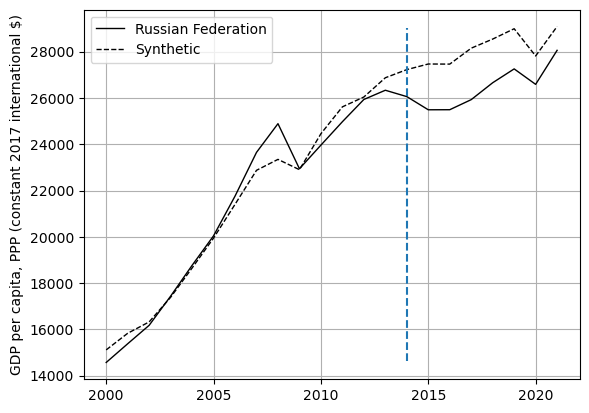

In [22]:
synth.path_plot(time_period=range(2000, 2022), treatment_time=2014)

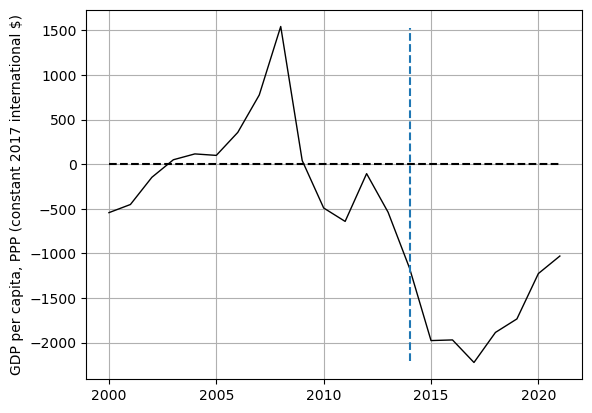

In [23]:
synth.gaps_plot(time_period=range(2000, 2022), treatment_time=2014)

In [24]:
synth.summary()

,V,treated,synthetic,sample mean
Oil rents (% of GDP),0.013,11.720,12.017,4.444
Total natural resources rents (% of GDP),0.187,17.603,15.415,7.662
Trade (% of GDP),0.064,56.953,75.461,82.090
"Agriculture, forestry, and fishing, value added (% of GDP)",0.067,4.733,6.101,12.462
"Industry (including construction), value added (% of GDP)",0.085,31.091,34.471,29.383
"Services, value added (% of GDP)",0.185,51.317,52.432,50.634
Population density (people per sq. km of land area),0.138,8.801,114.457,232.429
GDP per capita growth (annual %),0.111,5.808,5.539,2.824
Gross capital formation (% of GDP),0.000,21.227,26.401,24.126
"special.1.Manufacturing, value added (% of GDP)",0.034,13.788,16.551,14.240


In [26]:
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
   scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
)

(1/67) Completed placebo test for Azerbaijan.
(2/67) Completed placebo test for Algeria.
(3/67) Completed placebo test for Bangladesh.
(4/67) Completed placebo test for Brunei Darussalam.
(5/67) Completed placebo test for Albania.
(6/67) Completed placebo test for Botswana.
(7/67) Completed placebo test for Belarus.
(8/67) Completed placebo test for Argentina.
(9/67) Completed placebo test for Belize.
(10/67) Completed placebo test for Congo, Rep..
(11/67) Completed placebo test for Cote d'Ivoire.
(12/67) Completed placebo test for Chile.
(13/67) Completed placebo test for Colombia.
(14/67) Completed placebo test for Georgia.
(15/67) Completed placebo test for El Salvador.
(16/67) Completed placebo test for Bosnia and Herzegovina.
(17/67) Completed placebo test for Dominican Republic.
(18/67) Completed placebo test for Ghana.
(19/67) Completed placebo test for Hong Kong SAR, China.
(20/67) Completed placebo test for Guatemala.
(21/67) Completed placebo test for Burkina Faso.
(22/67) Co

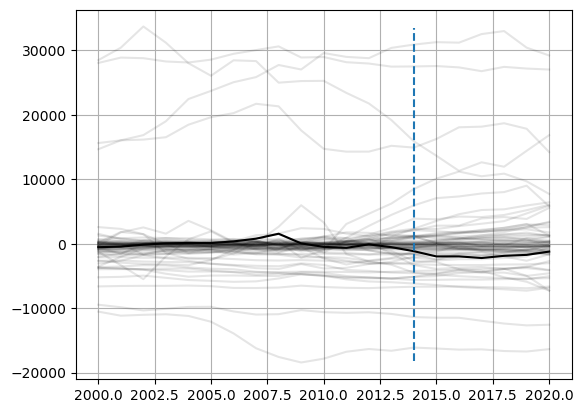

In [27]:
placebo_test.gaps_plot(
    time_period=range(2000, 2022), treatment_time=2014
)

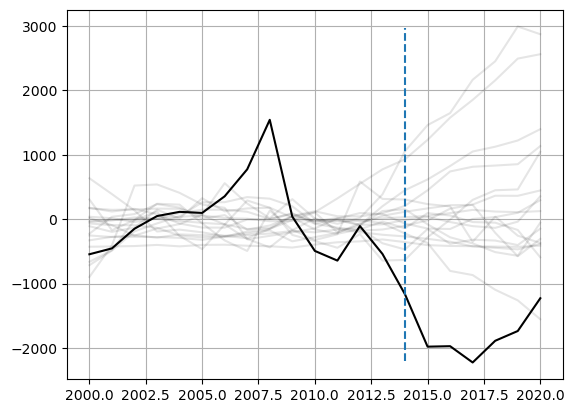

In [28]:
placebo_test.gaps_plot(
    time_period=range(2000, 2022),
    treatment_time=2014,
    mspe_threshold=0.5,
)

In [29]:
placebo_test.pvalue(treatment_time=2014)

0.22058823529411764